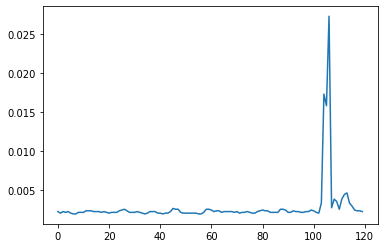

In [1]:
import sys

sys.path.append('../')
from tsdr import tsdr

import matplotlib.pyplot as plt
import numpy as np

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
short_spike_series = data_df['s-user_latency'].to_numpy()
plt.plot(short_spike_series)

In [2]:
from numpy.lib.stride_tricks import sliding_window_view
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

sel = ar_select_order(short_spike_series, maxlag=int(short_spike_series.size*0.1), ic='aic')
model_fit = sel.model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  120
Model:                     AutoReg(5)   Log Likelihood                 534.216
Method:               Conditional MLE   S.D. of innovations              0.002
Date:                Mon, 31 Jan 2022   AIC                          -1054.431
Time:                        00:06:29   BIC                          -1035.217
Sample:                             5   HQIC                         -1046.632
                                  120                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.888      0.004       0.000       0.002
y.L1           0.5113      0.092      5.580      0.000       0.332       0.691
y.L2           0.3393      0.103      3.287      0.0

In [3]:
r = model_fit.ar_lags[-1]
windows = sliding_window_view(short_spike_series, r)
sig2 = model_fit.sigma2
coef = model_fit.params

# xi = short_spike_series
pred = model_fit.get_prediction()
print(pred.summary_frame())

         mean   mean_se  mean_ci_lower  mean_ci_upper
0         NaN       NaN            NaN            NaN
1         NaN       NaN            NaN            NaN
2         NaN       NaN            NaN            NaN
3         NaN       NaN            NaN            NaN
4         NaN       NaN            NaN            NaN
..        ...       ...            ...            ...
115  0.002939  0.002324      -0.001617       0.007495
116  0.002434  0.002324      -0.002122       0.006989
117  0.002645  0.002324      -0.001911       0.007201
118  0.002667  0.002324      -0.001889       0.007223
119  0.002600  0.002324      -0.001956       0.007156

[120 rows x 4 columns]


In [4]:
preds = pred.summary_frame()[r:]['mean'].to_numpy()

scores = []
for i, x in enumerate(short_spike_series):
    if i >= short_spike_series.size - r:
        break
    scores.append((x - preds[i]) ** 2 / sig2)

plt.plot(scores)

[ 0.00239005  0.00231503  0.00219871  0.00221908  0.00238633  0.0024211
  0.00232571  0.00241996  0.00252491  0.00244806  0.00238892  0.00239208
  0.00243051  0.00238338  0.00238203  0.00240326  0.00228377  0.00231685
  0.00241176  0.00235879  0.0024385   0.00257605  0.00258426  0.00246949
  0.00229402  0.00231755  0.00242096  0.00244301  0.00238872  0.00226523
  0.00221458  0.00229276  0.00245285  0.00246774  0.00236834  0.00227661
  0.00224584  0.00227156  0.00229677  0.00233203  0.00239988  0.00264972
  0.00267601  0.00248036  0.00233532  0.00222666  0.00232788  0.00238234
  0.00231215  0.00229361  0.00229361  0.00224248  0.00220854  0.00234924
  0.00262563  0.00266596  0.00245311  0.00233798  0.00243387  0.00254866
  0.00239743  0.0023396   0.00246893  0.00243852  0.00239742  0.00236483
  0.00238203  0.00235213  0.00230098  0.00238921  0.00242847  0.00237017
  0.00226523  0.00226572  0.00242896  0.00253341  0.00252308  0.00245944
  0.00242017  0.00237087  0.00232556  0.00238387  0.

IndexError: index 115 is out of bounds for axis 0 with size 115

In [54]:
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
import numpy as np

class ARAD:
    maxlag: int
    def __init__(self, maxlag: int = 0):
        self.maxlag = maxlag
    
    def score(self, x: np.ndarray) -> list[float]:
        if self.maxlag == 0: maxlag = int(x.size * 0.2) 
        sel = ar_select_order(x, maxlag=maxlag, trend='ct', ic='aic')
        model_fit = sel.model.fit()
        r = 0 if model_fit.ar_lags is None else model_fit.ar_lags[-1]
        sig2 = model_fit.sigma2

        pred = model_fit.get_prediction()
        preds = pred.summary_frame()[r:]['mean']

        scores: list[float] = []
        for i, xi in enumerate(x):
            if i >= x.size - r:
                break
            scores.append((xi - preds[i+r]) ** 2 / sig2)
        return scores


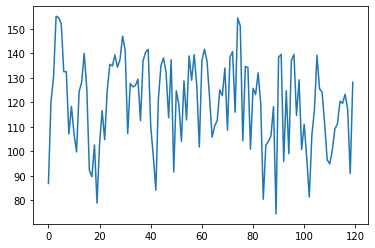

In [46]:
# White-noise
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-cpu-hog_2.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
white_noise_series = data_df['c-orders_network_receive_packets_total'].to_numpy()
plt.plot(white_noise_series)

In [34]:
from scipy.stats import zscore

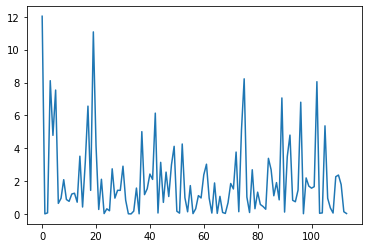

In [47]:
arad = ARAD()
scores = arad.score(zscore(white_noise_series))
plt.plot(scores)

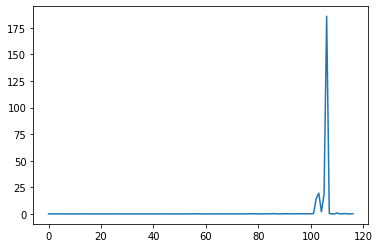

In [48]:
arad = ARAD()
scores = arad.score(zscore(short_spike_series))
plt.plot(scores)

[15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.
 15. 15. 15. 15. 15. 15. 15. 15. 15. 16. 14.]


/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


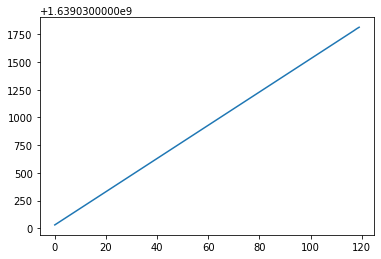

In [57]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user-db_pod-cpu-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
liner_series = data_df['c-catalogue_last_seen'].to_numpy()
plt.plot(liner_series)
np.diff(liner_series)

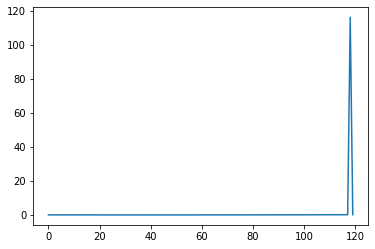

In [55]:
arad = ARAD()
scores = arad.score(zscore(liner_series))
plt.plot(scores)